#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков,-разделение-на-выборки" data-toc-modified-id="Создание-признаков,-разделение-на-выборки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков, разделение на выборки</a></span></li><li><span><a href="#Подбор-моделей" data-toc-modified-id="Подбор-моделей-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Подбор моделей</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Данные загружены, столбец с датами преобразован в тип `datetime`, индексы заменены на временную шкалу, выполнена сортировка по возрастанию времени.  
Представлены даты с 1 марта 2018 года по 31 августа 2018 года
Проведено ресемлирование по одному часу (суммарное количество заказов за один час).  

## Анализ

Проанализируем полученные данные.  

Посмотрим на общую картину за все полгода.

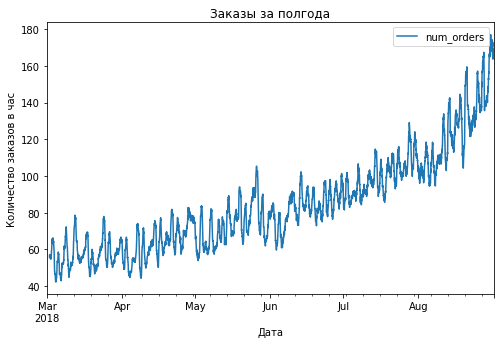

In [3]:
data.rolling(24).mean().plot(xlabel='Дата', ylabel='Количество заказов в час', title='Заказы за полгода', figsize=(8,5));

Из графика видно, что количество заказов плавно растет в течение шести месяцев.  
Попробуем уменьшить масштаб - возьмем промежуток в несколько дней.

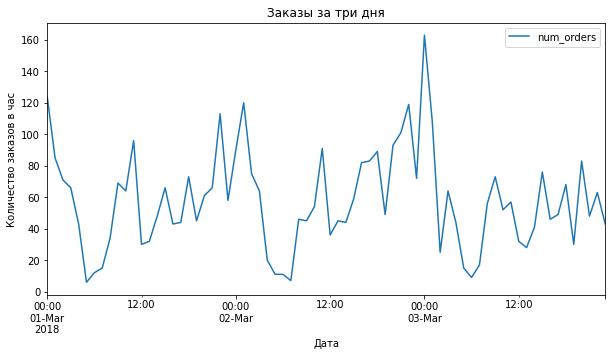

In [4]:
data['2018-03-01':'2018-03-03'].plot(xlabel='Дата', ylabel='Количество заказов в час', title='Заказы за три дня', figsize=(10,5));

По графику видно, что количество заказов зависит от времени - минимум всего заказов наблюдается в 6 утра, максимум - за пару часов до полуночи.

Найдем суточную сезонную составляющую, чтобы продемонстрировать эту закономерность.

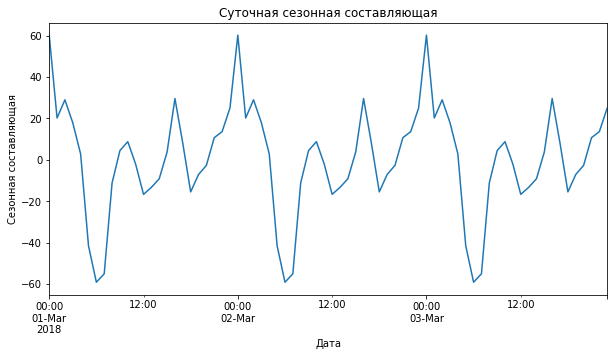

In [5]:
decomposed = seasonal_decompose(data) 
decomposed.seasonal['2018-03-01':'2018-03-03'].plot(xlabel='Дата', ylabel='Сезонная составляющая', title='Суточная сезонная составляющая', figsize=(10,5));

Выясним, есть ли недельная сезонность в данных.

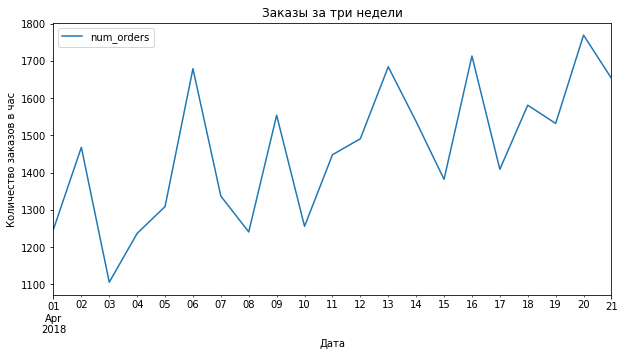

In [6]:
data_weekly = data.resample('1D').sum()
data_weekly['2018-04-01':'2018-04-21'].plot(xlabel='Дата', ylabel='Количество заказов в час', title='Заказы за три недели', figsize=(10,5));

Найдем недельную сезонную составляющую.

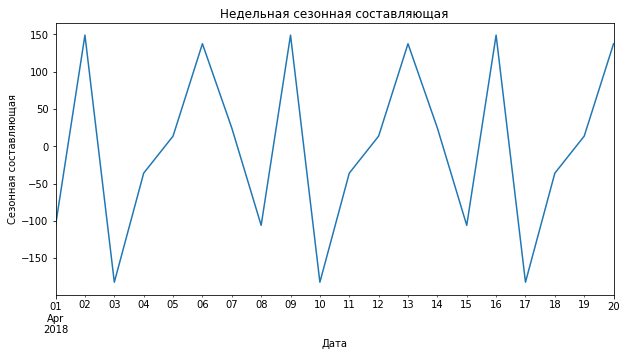

In [7]:
decomposed = seasonal_decompose(data_weekly) 
decomposed.seasonal['2018-04-01':'2018-04-20'].plot(xlabel='Дата', ylabel='Сезонная составляющая', title='Недельная сезонная составляющая', figsize=(10,5));

По графикам видно, что в данных так же присутствует недельная сезонность.

**Вывод**  
По результатам анализа мы выяснили, что количество заказов постепенно росло на протяжении шести месяцев.  
Кроме того, были обнаружены суточная и недельная сезонность данных. Это необходимо учесть при создании признаков для обучения модели.

## Обучение

### Создание признаков, разделение на выборки

Прежде чем делить данные на обучающую и тестовую выборки, создадим признаки, по которым будут обучаться модели:  
1) Календарные признаки - время, день недели; 
2) "Отстающие значения", *lag_features* - предыдущие значения временного ряда подскажут, будет целевое значение расти или уменьшаться;  
3) Скользящее среднее - задает общий тренд временного ряда.

Функция для создания признаков:

In [8]:
# max_lag - сколько предыдущих значений временного ряда создать в качестве признаков
# rolling_mean_size - размер окна, по которому выполняется усреднение

def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour    
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Создадим признаки. Возьмем гиперпараметры функции кратными одним суткам, т.е. 24. Такое число выбрано из-за того, что в данных присутствует суточная сезонность.   
Можно также сделать гиперпараметры кратными неделе (равными 168), но это может сильно замедлить вычисления, поэтому остановимся на первом варианте.

In [9]:
make_features(data, 24, 24)
data.head(5)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Создадим выборки для обучения и тестирования.  
Для тестирования отберем 10% исходных данных.

In [10]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

train_features = train.drop(['num_orders'], axis=1)
test_features = test.drop(['num_orders'], axis=1)
train_target = train['num_orders']
test_target = test['num_orders']

Все готово для обучения моделей.

### Подбор моделей

Для обучения моделей и оценки результата будем использовать кросс-валидацию.  

Начнем с модели линейной регрессии.

In [11]:
model = LinearRegression()

tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=model, 
                       cv=tscv,
                       param_grid={},
                       scoring='neg_root_mean_squared_error')
cv_model = gsearch.fit(train_features, train_target)

print(f'RMSE {(-1)*cv_model.best_score_:.2f}')

RMSE 27.13


Неплохой результат, удовлетворяет условиям задачи.  

Теперь рассмотрим модель случайного леса.

In [12]:
model = RandomForestRegressor()
tscv = TimeSeriesSplit(n_splits=5)

grid_space={'max_depth':[3,5,10],
              'n_estimators':[10,30,40],
           }
gsearch = GridSearchCV(estimator=model, 
                       cv=tscv,
                       param_grid=grid_space,
                       scoring='neg_root_mean_squared_error')
cv_model = gsearch.fit(train_features, train_target)

print(f'Лучшие гиперпараметры {cv_model.best_params_}')
print(f'RMSE {(-1)*cv_model.best_score_:.2f}')

Лучшие гиперпараметры {'max_depth': 10, 'n_estimators': 40}
RMSE 25.52


Удалось улучшить результат.  Остановимся на этой модели.

## Тестирование

In [13]:
model = RandomForestRegressor(random_state=123, n_estimators=40, max_depth=10)
model.fit(train_features, train_target)
predicted_test = model.predict(test_features)

print(f'RMSE {mean_squared_error(predicted_test, test_target)**0.5:.2f}')

RMSE 44.84


Значение RMSE находится в допустимых пределах.  
Проверим модель на адекватность - предскажем значения предыдущими значениями ряда.

In [14]:
predicted_previous = test_target.shift()
predicted_previous.iloc[0] = train_target.iloc[-1]
print(f'RMSE {mean_squared_error(predicted_previous, test_target)**0.5:.2f}')

RMSE 58.86


RMSE значительно увеличилась. Это говорит об эффективности выбранной модели.

## Вывод

Проведена работа по прогнозированию количества заказов такси на основе данных за полгода.  

Данные были обработаны и проанализированы.  
Выявлены некоторые закономерности:  
* Рост общего числа заказов с марта по конец августа,  
* Зависимость количества заказов от времени суток.  

Для прогнозирования числа заказов в час использовались такие признаки, как месяц, день, время дня, день недели, значение числа заказов за предыдущие четыре часа.  На основе этих признаков были созданы две модели, лучшая из них была протестирована на выборке величиной 1/10 от всех данных. Модель показала хороший результат, удовлетворяющий условиям задачи. 